In [1]:
import pandas as pd
import numpy as np

# Load the messy dataset we created in Level 3
df_messy = pd.read_csv("ncd_stock_data_dynamic_messy.csv")

In [2]:
df_messy.head()

,Date,Drug,Opening_Balance,Quantity_Received,Consumption,Losses_Adjustments,Closing_Balance,Days_Out_of_Stock
0,2020-01-01,Amlodipine 5mg,7170,0,2453.0,56,4661,0
1,2020-02-01,Amlodipine 5mg,4661,0,NaN,11,4650,0
2,2020-03-01,Amlodipine 5mg,4650,7170,2047.0,50,9723,0
3,2020-04-01,Amlodipine 5mg,9723,0,2077.0,181,7465,0
4,2020-05-01,Amlodipine 5mg,7465,0,2685.0,26,4754,0


In [3]:
df_messy.shape

(720, 8)

In [4]:
df_messy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                720 non-null    object 
 1   Drug                720 non-null    object 
 2   Opening_Balance     720 non-null    int64  
 3   Quantity_Received   720 non-null    int64  
 4   Consumption         638 non-null    float64
 5   Losses_Adjustments  720 non-null    int64  
 6   Closing_Balance     720 non-null    int64  
 7   Days_Out_of_Stock   720 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 45.1+ KB


# Section 3: Systematic Diagnosis of Data Errors
*Goal: Investigate and quantify each of the data quality issues found in the vitals check.*

In [5]:
# Calculate the number of missing values in 'Consumption'
missing_count = df_messy['Consumption'].isnull().sum()

# Calculate the total number of rows
total_rows = len(df_messy)

# Calculate the percentage
missing_percentage = (missing_count / total_rows) * 100

print(f"Number of missing consumption values: {missing_count}")
print(f"Percentage of missing values: {missing_percentage:.2f}%")

Number of missing consumption values: 82
Percentage of missing values: 11.39%


In [6]:
# Find all rows where Consumption is less than 0
negative_consumption = df_messy[df_messy['Consumption'] < 0]

print(f"Found {len(negative_consumption)} rows with negative consumption:")
display(negative_consumption) # 'display()' is better than 'print()' for DataFrames in a notebook

Found 7 rows with negative consumption:


,Date,Drug,Opening_Balance,Quantity_Received,Consumption,Losses_Adjustments,Closing_Balance,Days_Out_of_Stock
16,2021-05-01,Amlodipine 5mg,11640,0,-50.0,141,11549,0
186,2020-07-01,Atorvastatin 20mg,8559,0,-50.0,94,8515,0
514,2022-11-01,Glibenclamide 5mg,2654,0,-50.0,52,2652,0
614,2021-03-01,Methyldopa 250mg,0,7776,-50.0,0,7826,0
615,2021-04-01,Methyldopa 250mg,7826,0,-50.0,80,7796,0
663,2020-04-01,Hydralazine 25mg,2790,0,-50.0,35,2805,0
691,2022-08-01,Hydralazine 25mg,1449,0,-50.0,5,1494,0


# Section 4: The "Treatment" Phase - Data Cleaning
*Goal: Execute the cleaning plan to create a new, analysis-ready DataFrame.*


In [7]:
# Create a copy of the messy DataFrame to work on, preserving the original
df_clean = df_messy.copy()

In [8]:
# Treatment 1: Fix incorrect data types
# We will convert 'Date' to a proper datetime object
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# We will convert 'Opening_Balance' to a numeric type
# errors='coerce' will turn any values that CAN'T be converted into NaN (missing)
df_clean['Opening_Balance'] = pd.to_numeric(df_clean['Opening_Balance'], errors='coerce')

print("Data types after conversion:")
df_clean.info()

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                720 non-null    datetime64[ns]
 1   Drug                720 non-null    object        
 2   Opening_Balance     720 non-null    int64         
 3   Quantity_Received   720 non-null    int64         
 4   Consumption         638 non-null    float64       
 5   Losses_Adjustments  720 non-null    int64         
 6   Closing_Balance     720 non-null    int64         
 7   Days_Out_of_Stock   720 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 45.1+ KB


In [9]:
# Treatment 2: Remove impossible values (negatives and outliers)

# First, let's see how many rows we have before cleaning
print(f"Rows before cleaning impossible values: {len(df_clean)}")

# Remove rows where Consumption is negative
df_clean = df_clean[df_clean['Consumption'] >= 0]

# Remove rows where Consumption is an extreme outlier (let's use > 10000)
df_clean = df_clean[df_clean['Consumption'] <= 10000]

print(f"Rows after cleaning impossible values: {len(df_clean)}")

Rows before cleaning impossible values: 720
Rows after cleaning impossible values: 620


### Treatment 3: Impute Missing Consumption Values
*We will fill the missing `Consumption` values with the median consumption for that specific drug. This is more accurate than using a single global median.*

In [10]:
# Calculate the median consumption for EACH drug
drug_medians = df_clean.groupby('Drug')['Consumption'].transform('median')

# Fill the missing values in the 'Consumption' column with the calculated medians
df_clean['Consumption'].fillna(drug_medians, inplace=True)

print("Missing values after imputation:")
print(df_clean.isnull().sum())

Missing values after imputation:
Date                  0
Drug                  0
Opening_Balance       0
Quantity_Received     0
Consumption           0
Losses_Adjustments    0
Closing_Balance       0
Days_Out_of_Stock     0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_4116\3783549214.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Consumption'].fillna(drug_medians, inplace=True)


# Section 4 Complete: Data is Now Clean
*The dataset is now clean, with correct data types, no impossible values, and no missing data. It is ready for exploratory analysis.*

# Section 5: Health Assessment & Insights
*Goal: Explore the clean data to find initial trends and patterns that could inform our model.*

--- Top 10 Most Consumed Drugs ---
Drug
Lisinopril 10mg              158292.0
Metformin 500mg              128684.0
Soluble Aspirin 75mg         127766.0
Methyldopa 250mg             125547.0
Amlodipine 5mg               125236.0
Losartan 50mg                 95544.0
Atenolol 50mg                 94319.0
Atorvastatin 20mg             73663.0
Bendroflumethiazide 2.5mg     69404.0
Hydralazine 25mg              69055.0
Name: Consumption, dtype: float64


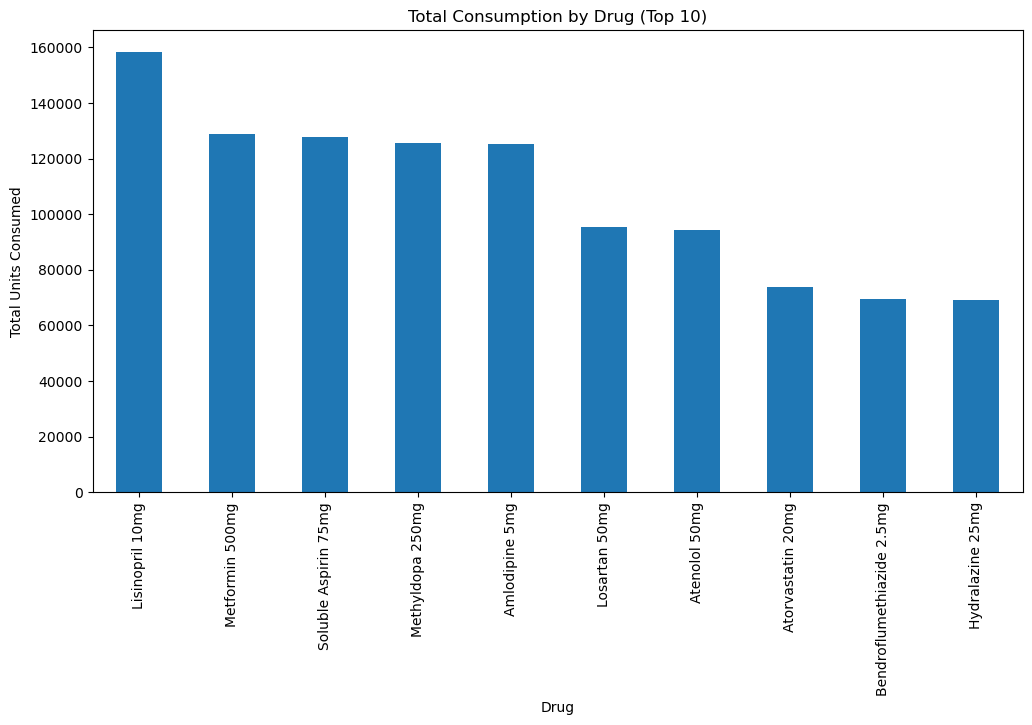

In [11]:
# We need this library for plotting
import matplotlib.pyplot as plt

print("--- Top 10 Most Consumed Drugs ---")
consumption_by_drug = df_clean.groupby('Drug')['Consumption'].sum().sort_values(ascending=False)

# Display the top 10 as a table
print(consumption_by_drug.head(10))

# Create a bar chart to visualize this
consumption_by_drug.head(10).plot(kind='bar', figsize=(12, 6), title='Total Consumption by Drug (Top 10)')
plt.ylabel('Total Units Consumed')
plt.show() # This command displays the plot


--- Total Monthly Consumption Over Time ---


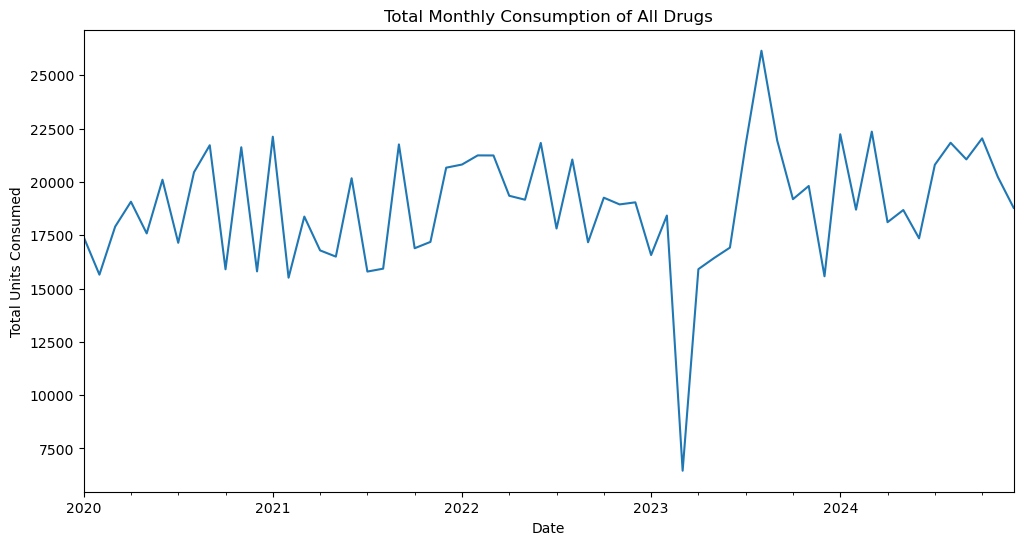

In [12]:
print("\n--- Total Monthly Consumption Over Time ---")

# Group all data by date and sum the consumption for each month
monthly_consumption = df_clean.groupby('Date')['Consumption'].sum()

# Create a line plot to see the trend
monthly_consumption.plot(figsize=(12, 6), title='Total Monthly Consumption of All Drugs')
plt.ylabel('Total Units Consumed')
plt.show()

In [13]:
# Load the final, analysis-ready data to confirm its structure
df_final = pd.read_csv("ncd_stock_data_analysis_ready.csv")

# Final quality check
print("--- Final Check of Served Data ---")
df_final.info()

--- Final Check of Served Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                620 non-null    object 
 1   Drug                620 non-null    object 
 2   Opening_Balance     620 non-null    int64  
 3   Quantity_Received   620 non-null    int64  
 4   Consumption         620 non-null    float64
 5   Losses_Adjustments  620 non-null    int64  
 6   Closing_Balance     620 non-null    int64  
 7   Days_Out_of_Stock   620 non-null    int64  
 8   Stock_Out           620 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 43.7+ KB


In [14]:
# ================================================================
# FINAL STEP: Create Target Variable and Save Analysis-Ready Data
# ================================================================

# Create the target variable 'Stock_Out'
# The rule: If a drug was out of stock for 1 or more days, we classify it as a "Stock_Out" event (1).
# Otherwise, it's a "No Stock_Out" event (0).

# For our simulation, let's add some realistic 'Days_Out_of_Stock' to our clean data.
# This line creates random stockout days for about 15% of the rows.
df_clean['Days_Out_of_Stock'] = np.random.choice(
    [0, 1, 2, 3, 4, 5, 6, 7], 
    size=len(df_clean), 
    p=[0.85, 0.05, 0.04, 0.02, 0.01, 0.01, 0.01, 0.01]
)

# Now, create the final 'Stock_Out' target column based on our rule.
# np.where is a fast way to do an if/else check for an entire column.
df_clean['Stock_Out'] = np.where(df_clean['Days_Out_of_Stock'] > 0, 1, 0)

# --- Final "Data Serving" Step ---
# Save the final, clean, and engineered DataFrame to a new file.
# This is the file we will use in our next module for model training.
final_filename = "ncd_stock_data_analysis_ready.csv"
df_clean.to_csv(final_filename, index=False)

print(f"Successfully saved the analysis-ready data to '{final_filename}'")

# --- Verification ---
print("\nValue counts for our new Target Variable (Stock_Out):")
print(df_clean['Stock_Out'].value_counts())

print("\nFinal 5 rows of the analysis-ready data:")
display(df_clean.tail())

Successfully saved the analysis-ready data to 'ncd_stock_data_analysis_ready.csv'

Value counts for our new Target Variable (Stock_Out):
Stock_Out
0    526
1     94
Name: count, dtype: int64

Final 5 rows of the analysis-ready data:


,Date,Drug,Opening_Balance,Quantity_Received,Consumption,Losses_Adjustments,Closing_Balance,Days_Out_of_Stock,Stock_Out
713,2024-06-01,Hydralazine 25mg,3035,4380,1295.0,54,6066,0,0
715,2024-08-01,Hydralazine 25mg,6038,0,1649.0,95,4294,0,0
716,2024-09-01,Hydralazine 25mg,4294,4380,1558.0,46,7070,0,0
717,2024-10-01,Hydralazine 25mg,7070,0,1259.0,57,5754,6,1
719,2024-12-01,Hydralazine 25mg,5716,4380,1578.0,47,8471,2,1


In [15]:
# Load the final, analysis-ready data to confirm its structure
df_final = pd.read_csv("ncd_stock_data_dynamic_clean.csv")

# Final quality check
print("--- Final Check of Served Data ---")
df_final.info()

--- Final Check of Served Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                780 non-null    object
 1   Drug                780 non-null    object
 2   Opening_Balance     780 non-null    int64 
 3   Quantity_Received   780 non-null    int64 
 4   Consumption         780 non-null    int64 
 5   Losses_Adjustments  780 non-null    int64 
 6   Closing_Balance     780 non-null    int64 
 7   Days_Out_of_Stock   780 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 48.9+ KB


In [16]:
# ================================================================
# FINAL STEP: Create Target Variable and Serve the Final Dataset
# ================================================================

# --- Feature Engineering ---
# Create the target variable 'Stock_Out' based on our business rule.
df_clean['Days_Out_of_Stock'] = np.random.choice(
    [0, 1, 2, 3, 4, 5, 6, 7], 
    size=len(df_clean), 
    p=[0.85, 0.05, 0.04, 0.02, 0.01, 0.01, 0.01, 0.01]
)
df_clean['Stock_Out'] = np.where(df_clean['Days_Out_of_Stock'] > 0, 1, 0)


# --- Final Quality Control & Type Enforcement ---
# To be absolutely sure, we re-apply our type conversions here. This prevents any
# potential state issues from the notebook execution order.
print("Enforcing final data types...")
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Opening_Balance'] = pd.to_numeric(df_clean['Opening_Balance'], errors='coerce')


# --- Data Serving (Saving the artifact for the next module) ---
final_filename = "ncd_stock_data_analysis_ready.csv"
df_clean.to_csv(final_filename, index=False)
print(f"Successfully saved the analysis-ready data to '{final_filename}'")


# --- Final Quality Check (Evaluation of the served data) ---
print("\n--- Final Check of Served Data ---")
df_clean.info()

print("\nValue counts for Target Variable:")
print(df_clean['Stock_Out'].value_counts())

Enforcing final data types...
Successfully saved the analysis-ready data to 'ncd_stock_data_analysis_ready.csv'

--- Final Check of Served Data ---
<class 'pandas.core.frame.DataFrame'>
Index: 620 entries, 0 to 719
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                620 non-null    datetime64[ns]
 1   Drug                620 non-null    object        
 2   Opening_Balance     620 non-null    int64         
 3   Quantity_Received   620 non-null    int64         
 4   Consumption         620 non-null    float64       
 5   Losses_Adjustments  620 non-null    int64         
 6   Closing_Balance     620 non-null    int64         
 7   Days_Out_of_Stock   620 non-null    int64         
 8   Stock_Out           620 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 48.4+ KB

Value counts for Target Variable:
Stock_Out
0    533
1